In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
plt.rcParams.update({
    'font.size': 14,
    'legend.fontsize': 14
})

In [2]:
def dft(signal: np.array, fs: int, freq_range: tuple[float, float]):
    N = len(signal)
    T = N / fs
    t = np.arange(0, T, 1 / fs)
    freq_res = 1/T

    freq = np.arange(0, fs, freq_res)[:N // 2]
    # ys = np.zeros((N // 2))
    ys = np.abs(np.fft.fft(signal)[:N//2])

    min_check_freq = np.floor(freq_range[0] / freq_res) * freq_res
    max_check_freq = np.ceil(freq_range[1] / freq_res) * freq_res

    # for f in np.arange(min_check_freq, max_check_freq, freq_res):
    #     sin = np.sin(2 * np.pi * t * f)
    #     cos = np.cos(2 * np.pi * t * f)
    #
    #     real_component = np.dot(cos, signal)
    #     imag_component = np.dot(sin, signal)
    #
    #     amplitude = np.sqrt(real_component ** 2 + imag_component ** 2)
    #     nearest_idx = np.argmin(np.abs(freq - f))
    #     ys[nearest_idx] = amplitude


    range_idx = np.where((freq >= min_check_freq) & (freq <= max_check_freq))
    freq_limit_idx = np.where((freq >= 0) & (freq <= 1000))

    return ys[freq_limit_idx], freq[freq_limit_idx], range_idx


In [3]:
# RPM - (DFT/number_of_blades)*60
def fft_analysis(signal: np.array, fs: int, number_of_blades: int = 3, min_rpm: int = None, max_rpm: int = None):
    min_freq = (min_rpm * number_of_blades) / 60 if min_rpm is not None else 0
    max_freq = (max_rpm * number_of_blades) / 60 if max_rpm is not None else 1000

    Ys, freq, range_idx = dft(signal=signal, fs=fs, freq_range=(min_freq, max_freq))
    useful_freq = freq[range_idx]
    useful_ys = Ys[range_idx]

    base_freq = np.round(useful_freq[useful_ys == np.max(useful_ys)][0], 2)
    rpm = np.ceil((base_freq / number_of_blades) * 60)

    # Find harmonics
    harmonics = [base_freq]
    harmonic = 2
    while base_freq * harmonic <= 1000: # Useful frequency are up to 1000Hz
        nearest_idx = np.argmin(np.abs(freq - (base_freq * harmonic)))
        harmonics.append(freq[nearest_idx])
        harmonic += 1

    return Ys, freq, rpm, harmonics

### Analiza števila vrtlajev ventilatorjev na minuto

In [4]:
data_dict = dict({
    'a': [
        { 'blades': 10, 'min_rpm': 1100, 'max_rpm': 1600 }
    ],
    'b': [
        { 'blades': 5, 'min_rpm': 2200, 'max_rpm': 2800 }
    ],
    'c': [
        { 'blades': 3, 'min_rpm': 400, 'max_rpm': 900 },
        { 'blades': 3, 'min_rpm': 800, 'max_rpm': 1400 },
        { 'blades': 3, 'min_rpm': 2200, 'max_rpm': 2950 },
        { 'blades': 3, 'min_rpm': 1950, 'max_rpm': 2400 },
        { 'blades': 3, 'min_rpm': 1300, 'max_rpm': 1600 },
        { 'blades': 3, 'min_rpm': 1900, 'max_rpm': 2300 },
        { 'blades': 3, 'min_rpm': 1700, 'max_rpm': 2000 },
    ]
})

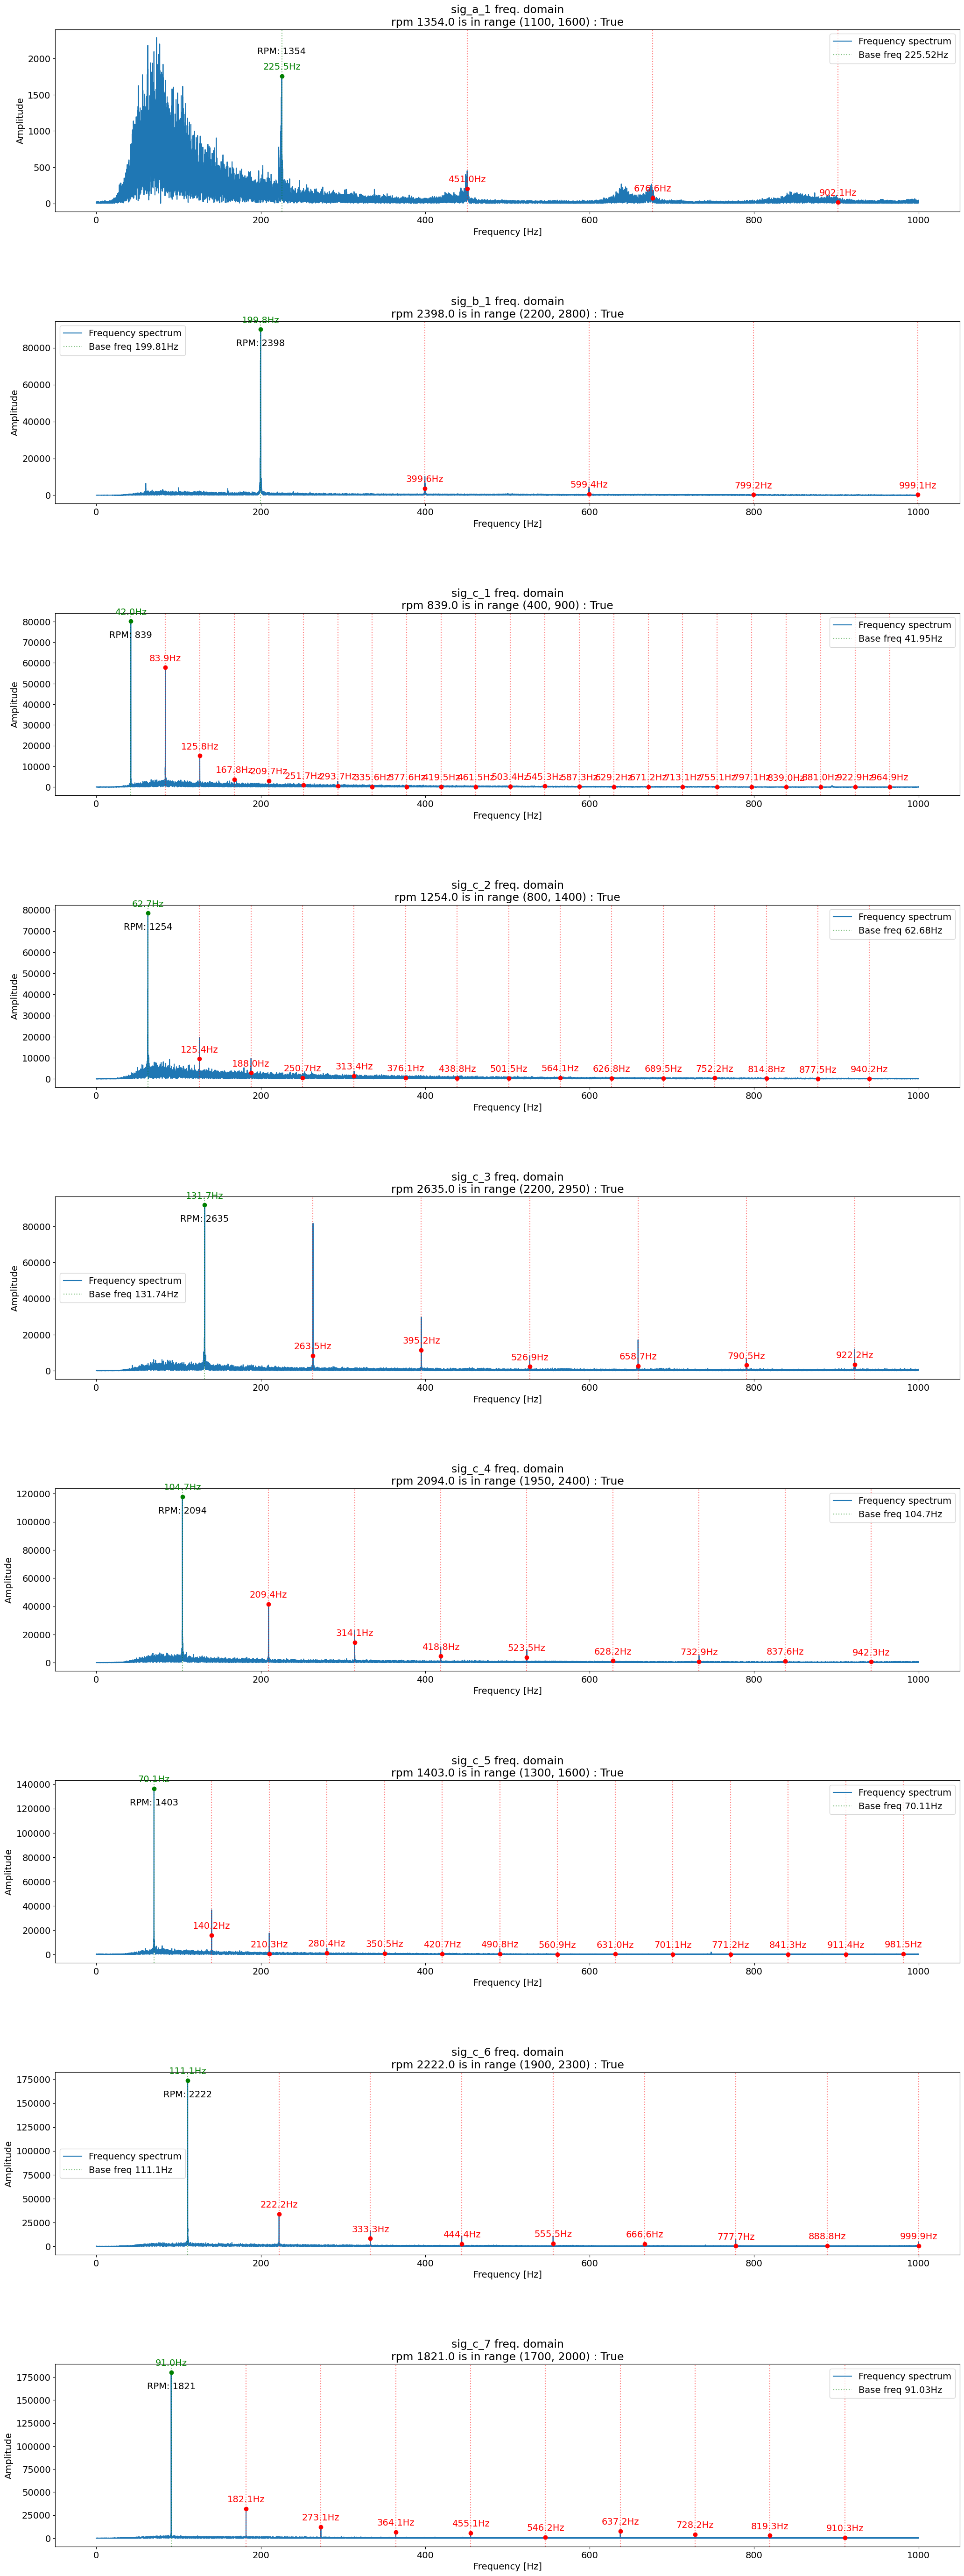

In [5]:
nrows = sum(len(data_dict[l]) for l in data_dict)
fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(25, 70), gridspec_kw={'hspace': 0.6})

for i, letter in enumerate(data_dict):
    for file_index in np.arange(len(data_dict[letter])):
        signal, fs = sf.read(f'data/sig_{letter}_{file_index + 1}.wav')
        N = len(signal)
        T = N/fs
        t = np.arange(0, T, 1/fs)
        max_rpm = data_dict[letter][file_index]['max_rpm']
        min_rpm = data_dict[letter][file_index]['min_rpm']

        Ys, freq, rpm, harmonics = fft_analysis(
            signal=signal,
            fs=fs,
            number_of_blades=data_dict[letter][file_index]['blades'],
            min_rpm=data_dict[letter][file_index]['min_rpm'],
            max_rpm=data_dict[letter][file_index]['max_rpm']
        )

        axs[i + file_index].plot(freq, Ys, label='Frequency spectrum')
        axs[i + file_index].set_title(f'sig_{letter}_{file_index + 1} freq. domain\nrpm {rpm} is in range ({min_rpm}, {max_rpm}) : {min_rpm <= rpm <= max_rpm}')
        axs[i + file_index].set_xlabel('Frequency [Hz]')
        axs[i + file_index].set_ylabel('Amplitude')
        axs[i + file_index].text(harmonics[0], np.max(Ys)*0.9, f'RPM: {rpm:.0f}', ha='center')

        axs[i + file_index].axvline(x=harmonics[0], color= 'g', linestyle=':', alpha=0.5, label=f'Base freq {harmonics[0]}Hz')
        axs[i + file_index].plot(harmonics[0], Ys[np.argmin(np.abs(freq - harmonics[0]))], 'go', markersize=6)
        axs[i + file_index].annotate(f'{harmonics[0]:.1f}Hz', (harmonics[0], Ys[np.argmin(np.abs(freq - harmonics[0]))]), textcoords="offset points", xytext=(0,10), ha='center', color='g')
        axs[i + file_index].legend()

        for harmonic_freq in harmonics:
            if harmonic_freq == harmonics[0]:
                continue
            harmonic_idx = np.argmin(np.abs(freq - harmonic_freq))
            harmonic_amp = Ys[harmonic_idx]

            axs[i + file_index].axvline(x=harmonic_freq, color= 'r', linestyle=':', alpha=0.5, label=f'Harmonic' if harmonic_freq == harmonics[1] else '')
            axs[i + file_index].plot(harmonic_freq, harmonic_amp, 'ro', markersize=6)
            axs[i + file_index].annotate(f'{harmonic_freq:.1f}Hz', (harmonic_freq, harmonic_amp), textcoords="offset points", xytext=(0,10), ha='center', color='r')

### Analiza odvisnosti frekvenčne vsebine od hitrosti vrtenja za signale sig_c_x

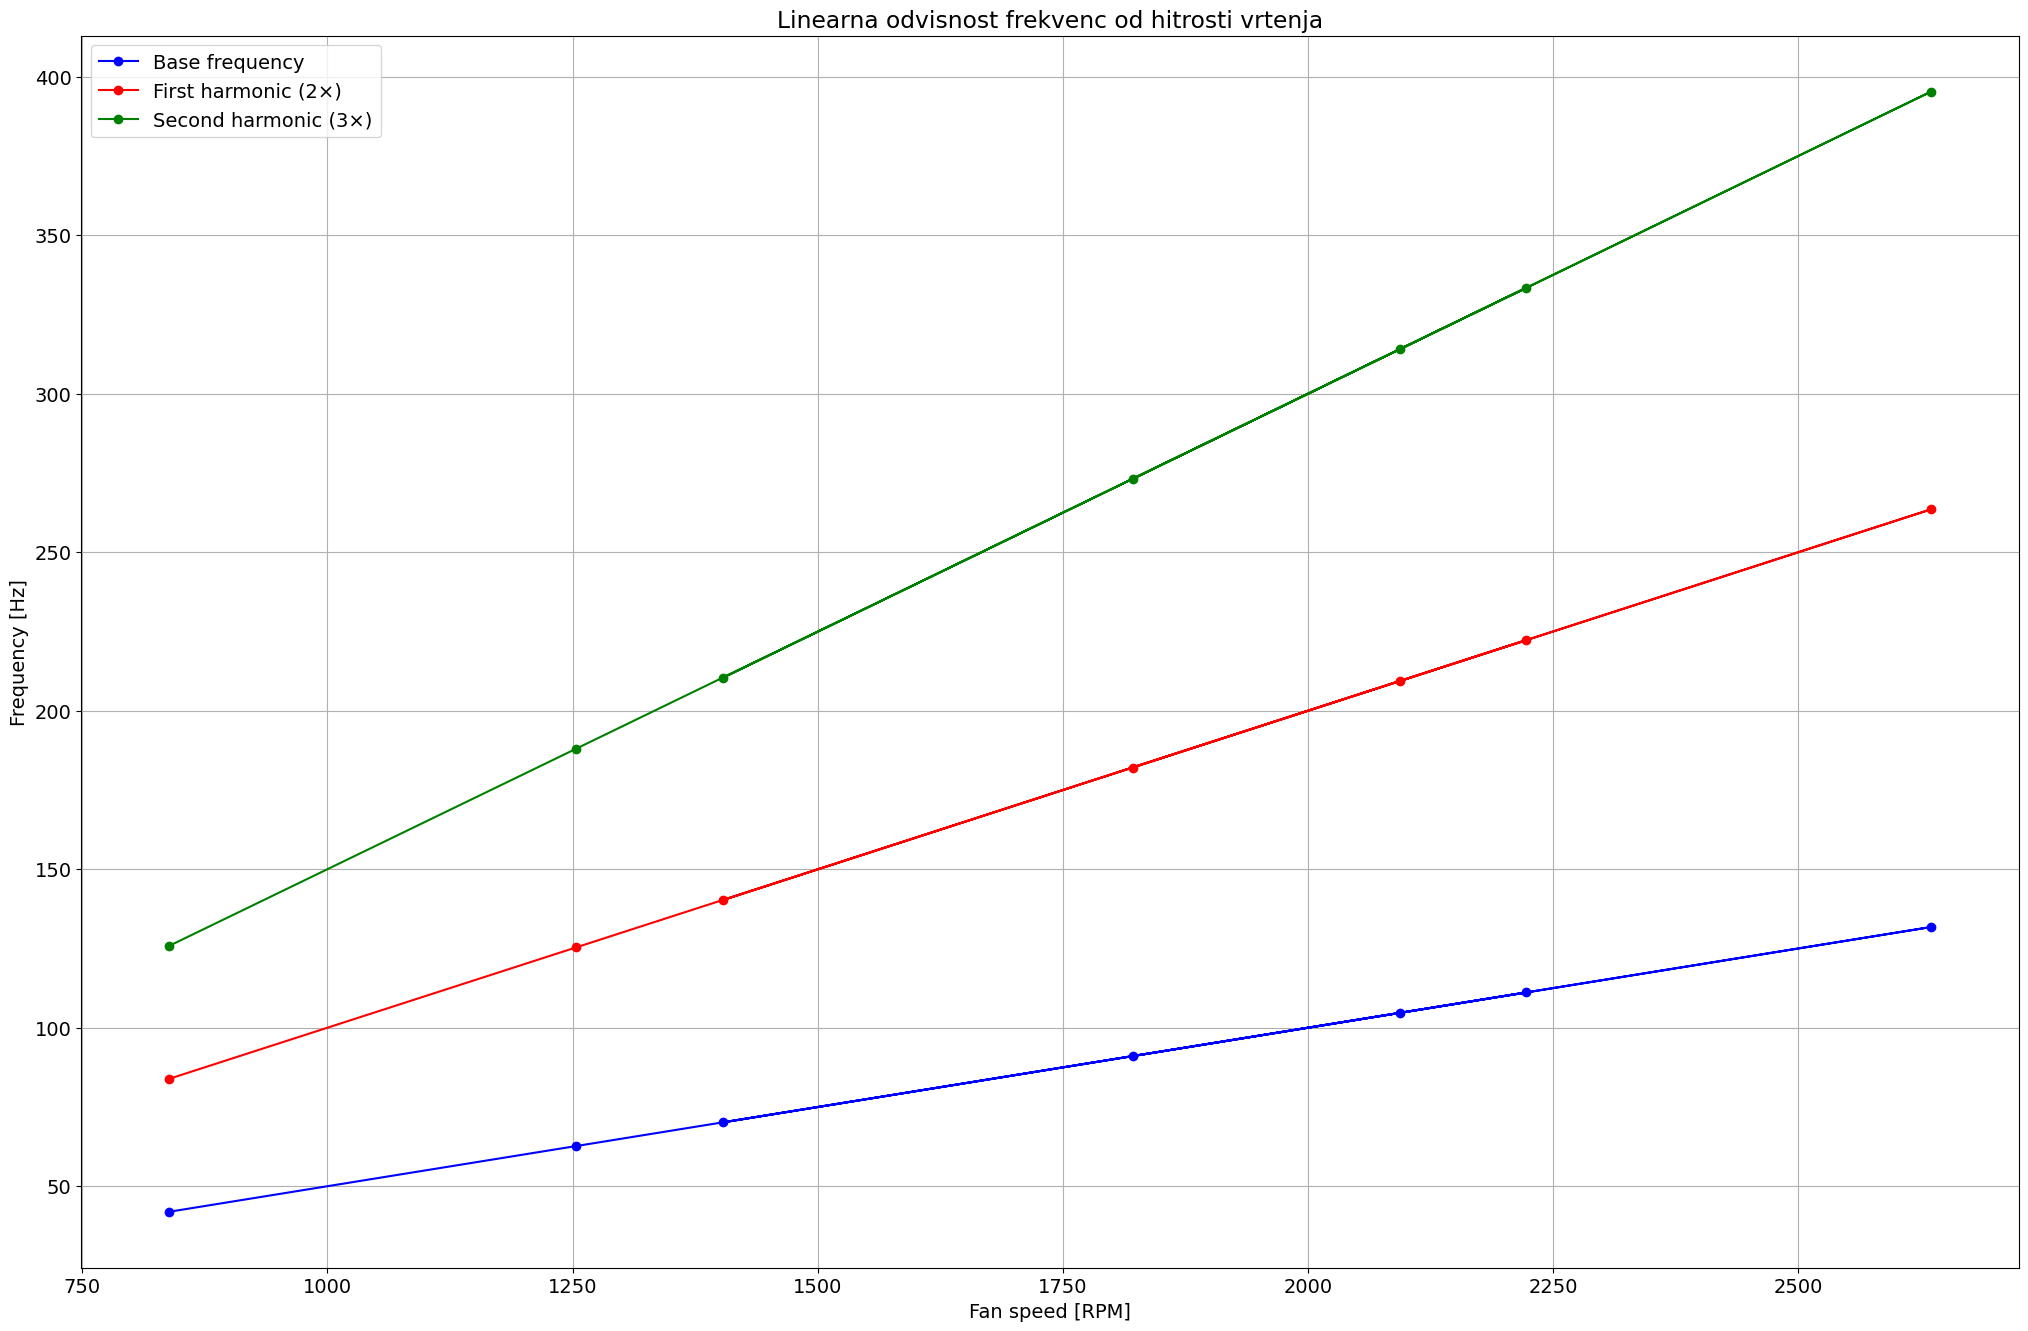

In [6]:
base_freqs = np.zeros(len(data_dict['c']))
rpm_values  = np.zeros(len(data_dict['c']))

for file_index in np.arange(len(data_dict['c'])):
    signal, fs = sf.read(f'data/sig_{letter}_{file_index + 1}.wav')
    N = len(signal)
    T = N/fs
    t = np.arange(0, T, 1/fs)
    max_rpm = data_dict[letter][file_index]['max_rpm']
    min_rpm = data_dict[letter][file_index]['min_rpm']

    Ys, freq, rpm, harmonics = fft_analysis(
        signal=signal,
        fs=fs,
        number_of_blades=data_dict[letter][file_index]['blades'],
        min_rpm=data_dict[letter][file_index]['min_rpm'],
        max_rpm=data_dict[letter][file_index]['max_rpm']
    )
    base_freqs[file_index] = harmonics[0]
    rpm_values[file_index] = rpm

plt.figure(figsize=(25, 16))
plt.plot(rpm_values, base_freqs, 'bo-', label='Base frequency')
plt.plot(rpm_values, base_freqs * 2, 'ro-', label='First harmonic (2×)')
plt.plot(rpm_values, base_freqs * 3, 'go-', label='Second harmonic (3×)')

plt.xlabel('Fan speed [RPM]')
plt.ylabel('Frequency [Hz]')
plt.title('Linearna odvisnost frekvenc od hitrosti vrtenja')
plt.legend()
plt.grid(True)
plt.show()